In [1]:
import os, warnings
warnings.simplefilter('ignore')
from neurocaps.extraction import TimeseriesExtractor
from neurocaps.analysis import CAP, merge_dicts
import numpy as np, joblib
from matplotlib.colors import LinearSegmentedColormap
from seaborn import diverging_palette

parcel_approach = {"Schaefer": {"n_rois": 100}}
#parcel_approach = {"AAL": {"version": "SPM12"}}

ncol = parcel_approach["Schaefer"]["n_rois"] if "Schaefer" in parcel_approach.keys() else 116
extractor = TimeseriesExtractor(parcel_approach=parcel_approach)
# Generating a fuller subject timeseries for later cap analysis
extractor.subject_timeseries = {str(x) : {f"run-{y}": np.random.rand(50,ncol) for y in range(1,4)} for x in range(1,11)}


          List of confound regressors that will be used during timeseries extraction if available in confound
          dataframe: ['cosine*', 'trans_x', 'trans_x_derivative1', 'trans_y', 'trans_y_derivative1', 'trans_z', 'trans_z_derivative1', 'rot_x', 'rot_x_derivative1', 'rot_y', 'rot_y_derivative1', 'rot_z', 'rot_z_derivative1', 'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05']
          


In [2]:
# Save randomly generated data in directory where jupyter notebook is running
output_dir = os.path.dirname(__vsc_ipynb_file__)

extractor.timeseries_to_pickle(output_dir=output_dir, file_name="sample_for_neurocaps_demo_timeseries.pkl")

with open("sample_for_neurocaps_demo_timeseries.pkl", "rb") as f:
    subject_timeseries = joblib.load(f)


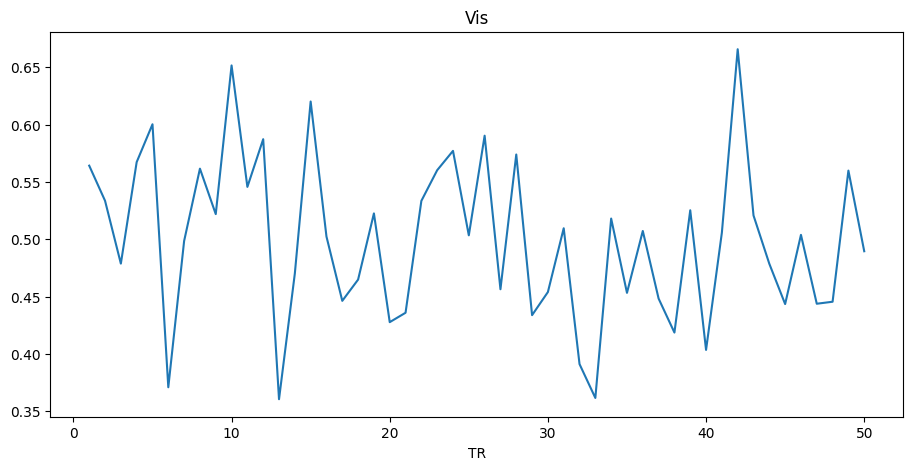

In [3]:
# Visualize Bold at network level
if ncol == 116:
    extractor.visualize_bold(subj_id="1",run=1, region="Cerebelum")
else:
    extractor.visualize_bold(subj_id="1",run=1, region="Vis")

Optimal cluster size for High ADHD is 10.



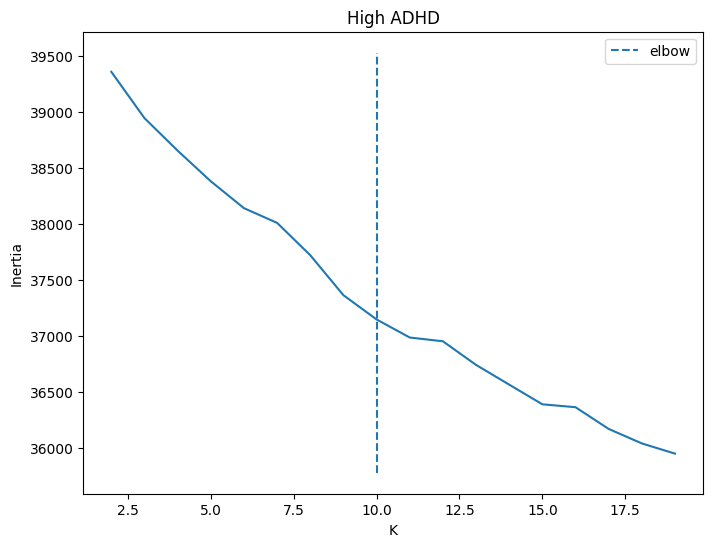

Optimal cluster size for Low ADHD is 8.



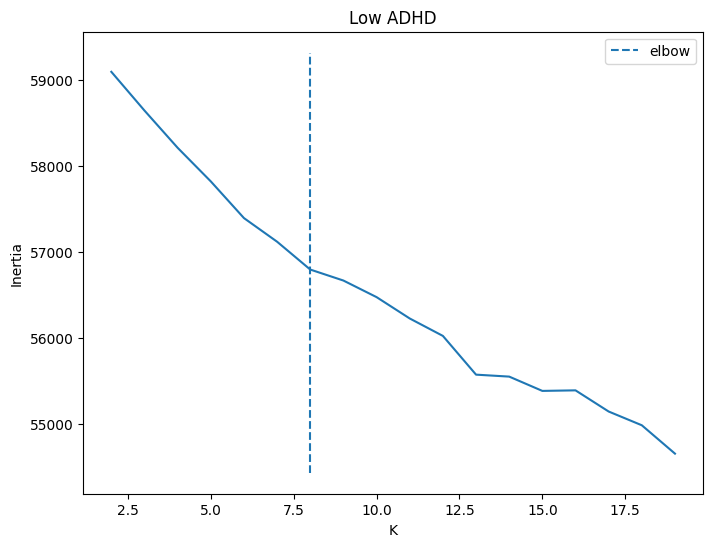

In [4]:
# Performing Cap analysis with groups, list of n_clusters, and elbow cluster selection method

cap_analysis = CAP(groups={"High ADHD": ["1","2","3","5"], "Low ADHD": ["4","6","7","8","9","10"]})

# When elbow method is specified, the associated plots will be shown, furthermore, the saved kmeans model for each group will automatically save to the optimal cluster size

cap_analysis.get_caps(subject_timeseries=extractor.subject_timeseries, runs=[1,2],
                      n_clusters=list(range(2,20)), cluster_selection_method="elbow", show_figs=True)

Optimal cluster size for High ADHD is 2.


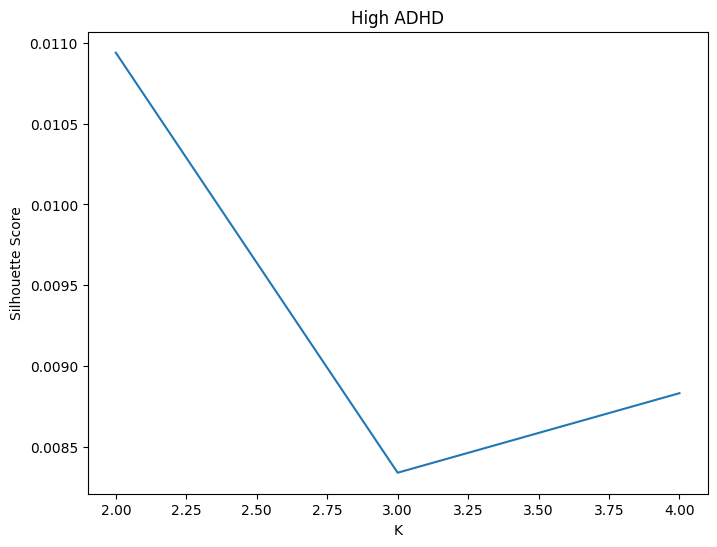

Optimal cluster size for Low ADHD is 3.


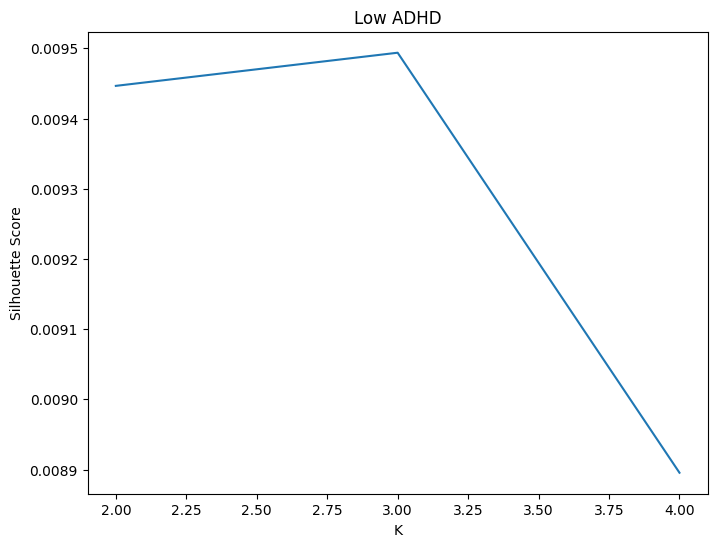

{'High ADHD': KMeans(n_clusters=2), 'Low ADHD': KMeans(n_clusters=3)}

In [5]:
# Performing Cap analysis with groups, list of n_clusters, and silhouette cluster selection method

cap_analysis.get_caps(subject_timeseries="sample_for_neurocaps_demo_timeseries.pkl",
                      n_clusters=list(range(2,5)),
                      cluster_selection_method="silhouette", show_figs=True)

# kmeans model automatically save to the optimal size
cap_analysis.kmeans

In [6]:
cap_analysis.parcel_approach = parcel_approach

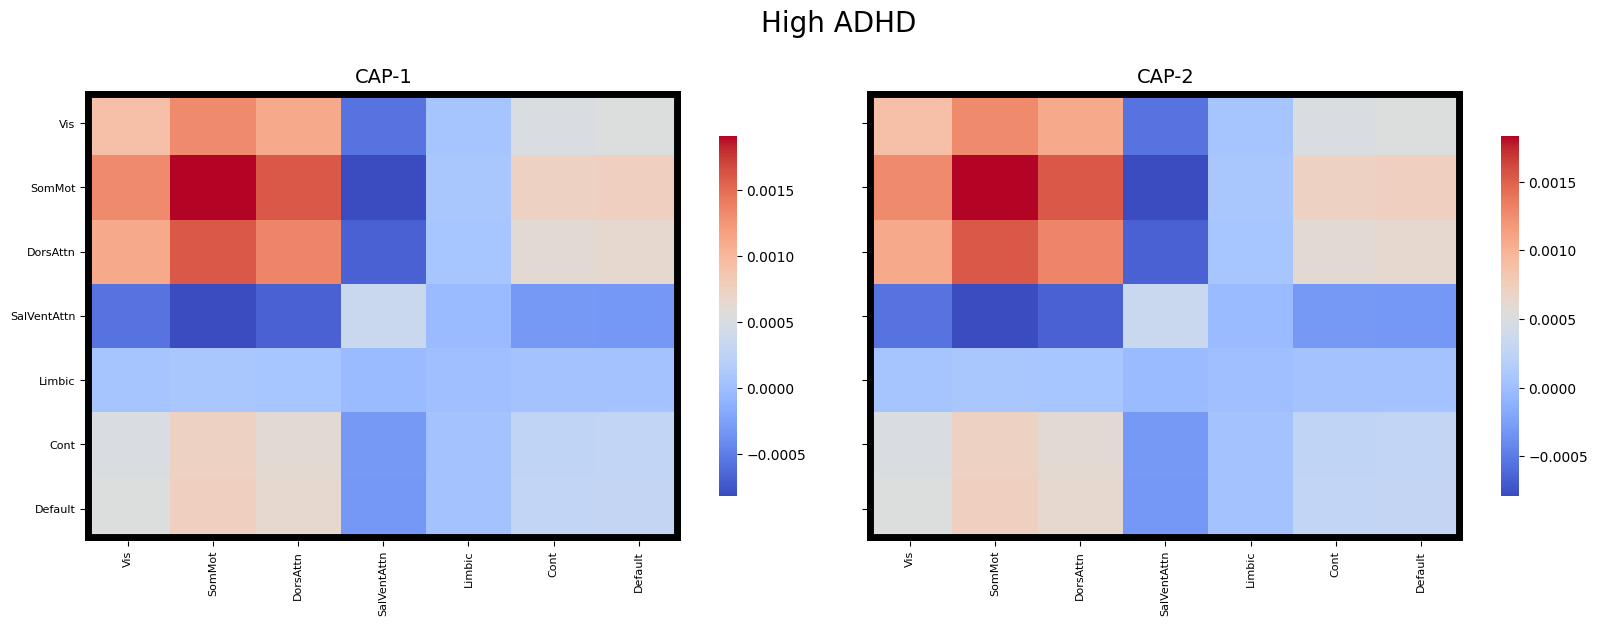

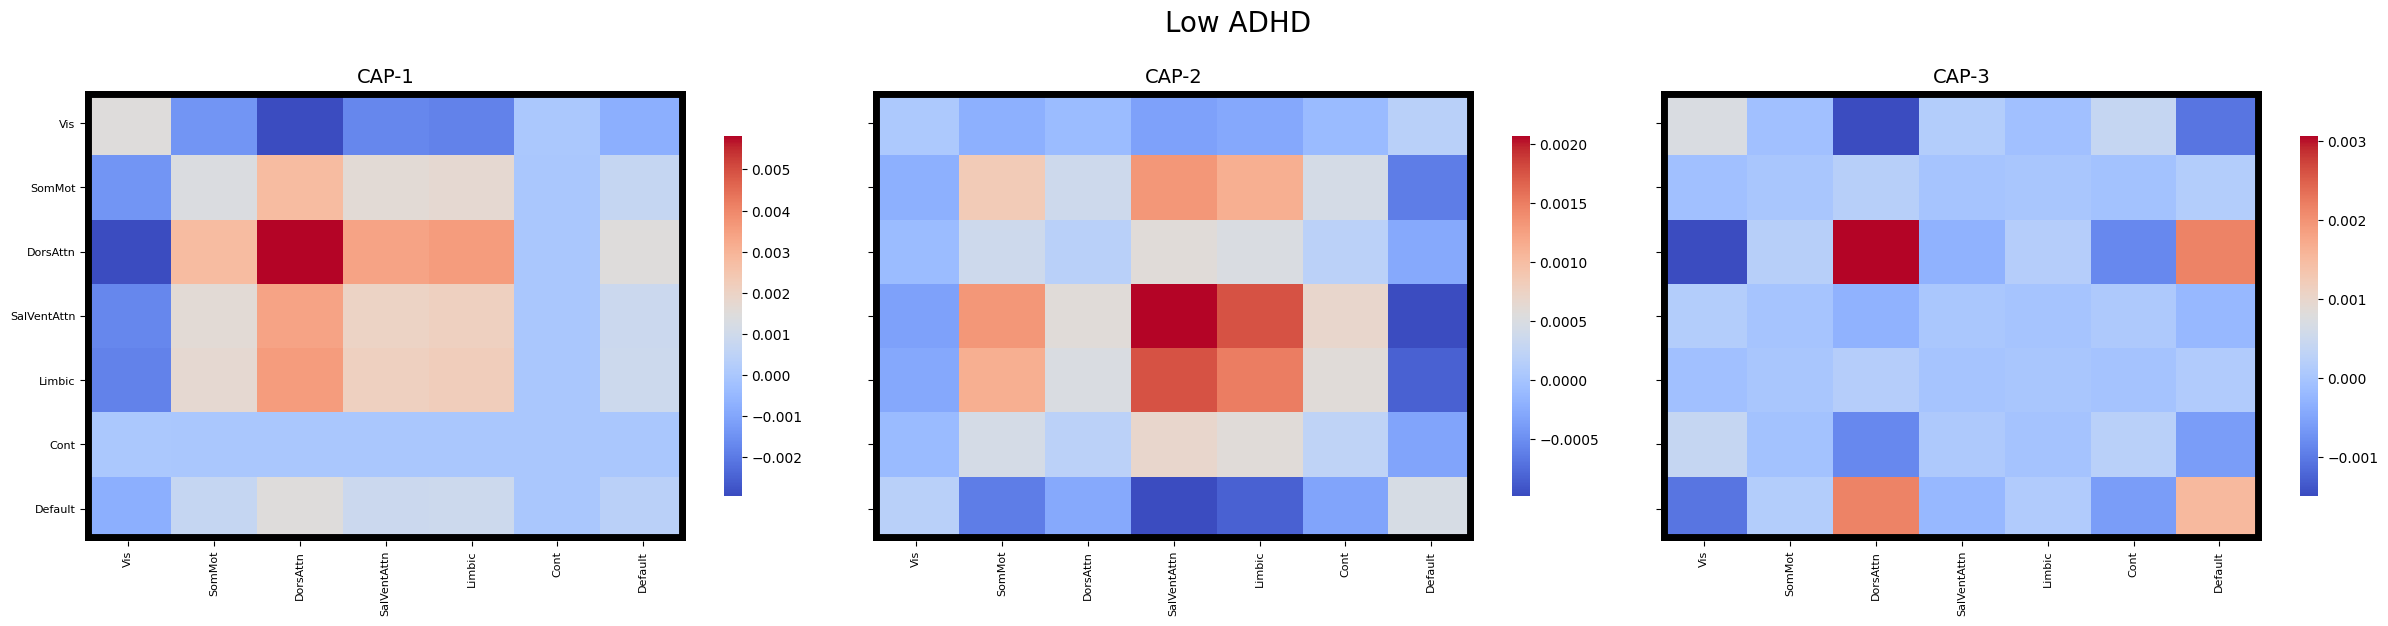

In [7]:
# Visualize Caps
cap_analysis.caps2plot(subplots=True, xlabel_rotation=90, sharey=True, borderwidths=10)

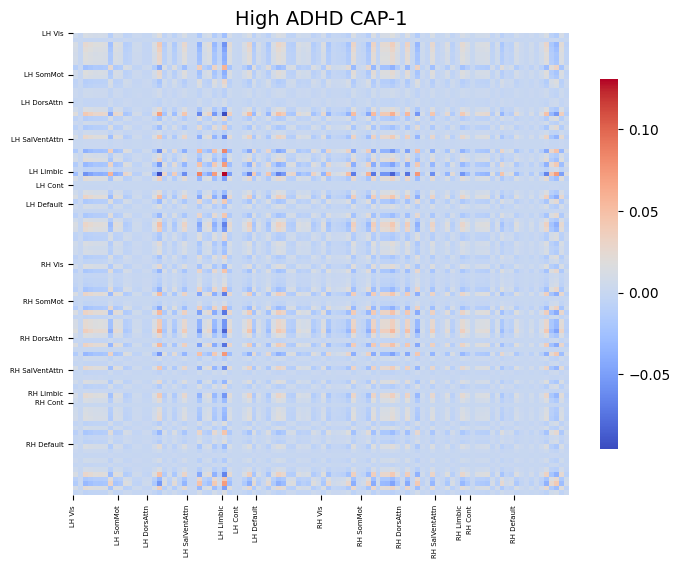

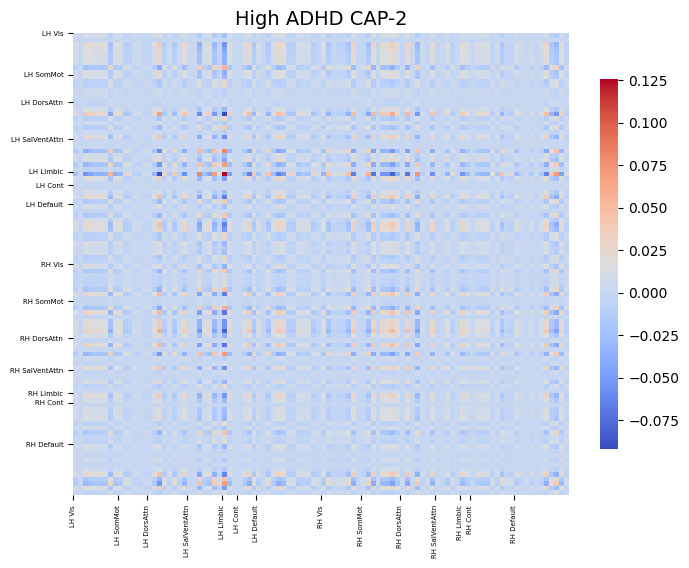

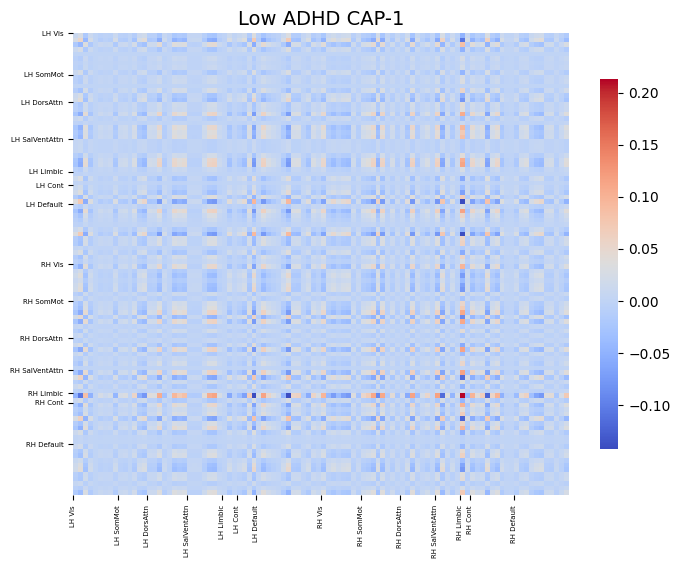

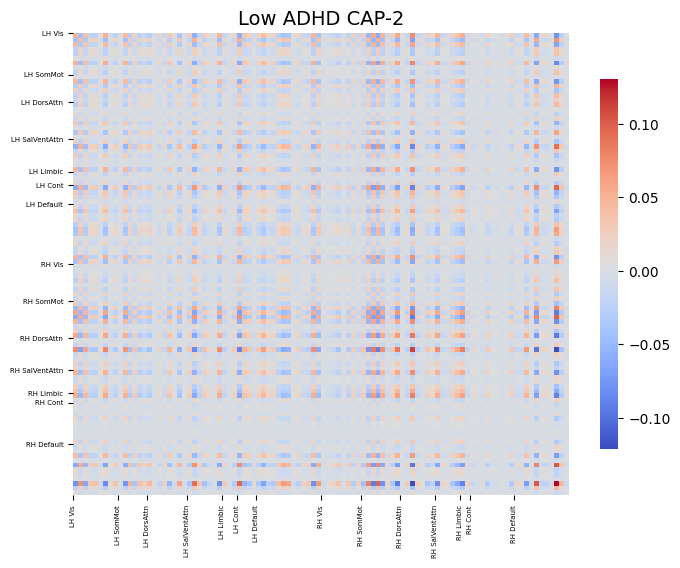

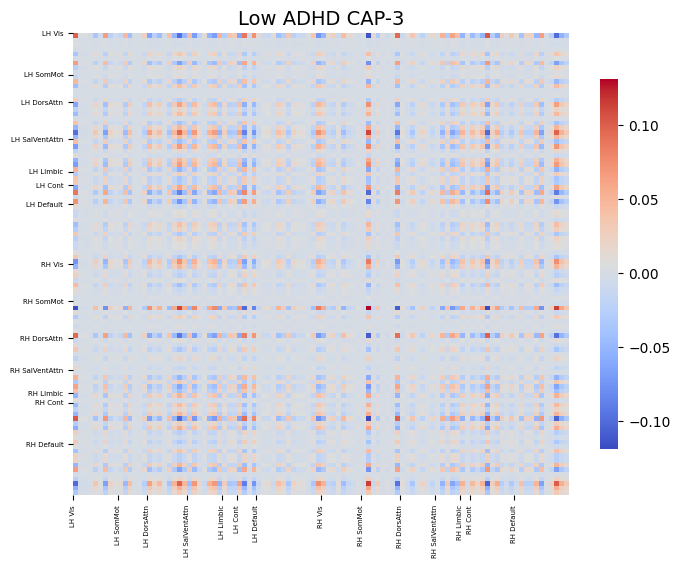

In [8]:
cap_analysis.caps2plot(subplots=False, yticklabels_size=5, wspace = 0.1, visual_scope="nodes", xlabel_rotation=90,
                       xticklabels_size = 5, hspace = 0.6, tight_layout = False)

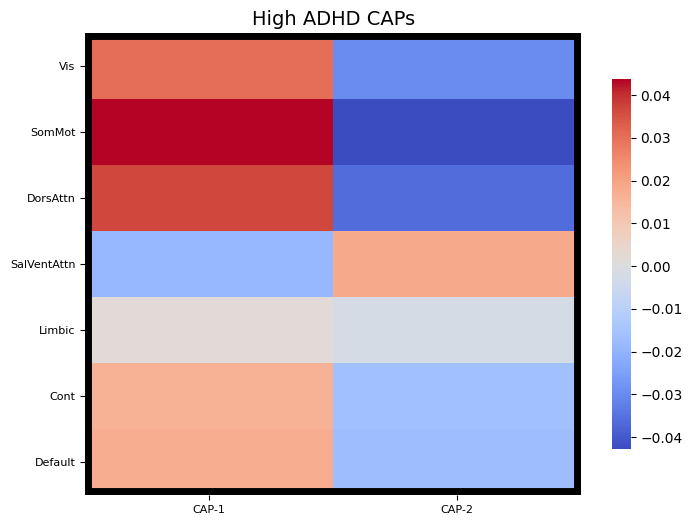

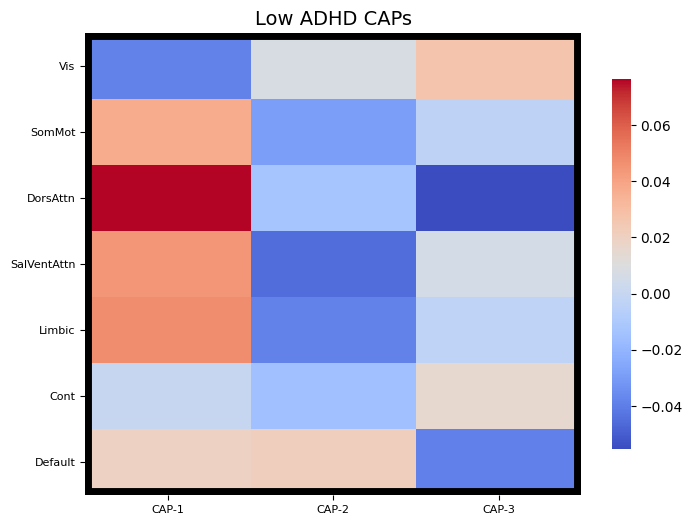

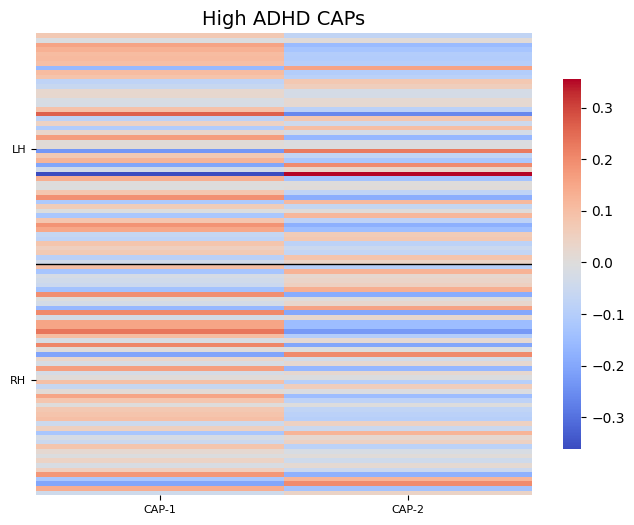

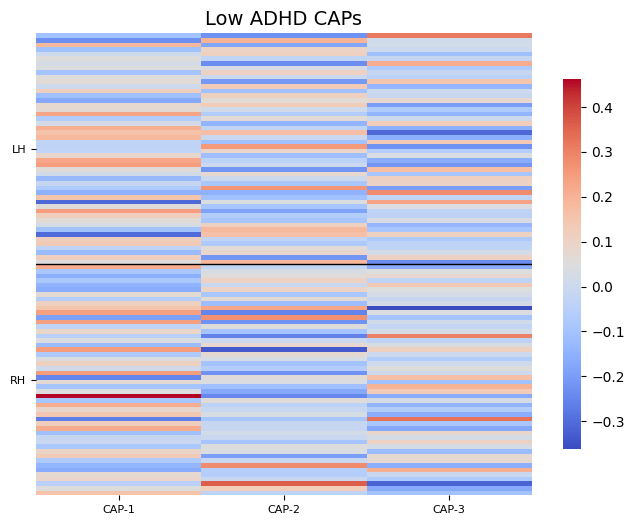

In [9]:
# Get regular heatmap 
cap_analysis.caps2plot(subplots=True, visual_scope="regions", plot_options="heatmap", borderwidths=10)
cap_analysis.caps2plot(subplots=True, visual_scope="nodes", plot_options="heatmap", hemisphere_labels = True)

In [10]:
cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries,tr=2,metrics="persistence",
                               return_df=True)

{'persistence':    Subject_ID      Group    Run     CAP-1     CAP-2     CAP-3
 0           1  High_ADHD  run-1  3.428571  3.714286  0.000000
 1           1  High_ADHD  run-2  3.000000  5.818182  0.000000
 2           1  High_ADHD  run-3  4.000000  4.000000  0.000000
 3           2  High_ADHD  run-1  4.000000  2.500000  0.000000
 4           2  High_ADHD  run-2  3.058824  2.823529  0.000000
 5           2  High_ADHD  run-3  4.000000  4.000000  0.000000
 6           3  High_ADHD  run-1  2.533333  3.875000  0.000000
 7           3  High_ADHD  run-2  4.166667  3.846154  0.000000
 8           3  High_ADHD  run-3  4.461538  3.230769  0.000000
 9           5  High_ADHD  run-1  3.571429  3.571429  0.000000
 10          5  High_ADHD  run-2  3.500000  4.833333  0.000000
 11          5  High_ADHD  run-3  4.615385  2.857143  0.000000
 12          4   Low_ADHD  run-1  3.090909  2.545455  3.166667
 13          4   Low_ADHD  run-2  2.800000  3.272727  3.272727
 14          4   Low_ADHD  run-3  2.5454

In [11]:
# Individual plots. In the event you wnat to merge TRs from two dictionaries conatining the same subject to find common CAPs across a task
subject_timeseries_1 = {str(x) : {f"run-{y}": np.random.rand(100,ncol) for y in range(1,4)} for x in range(1,11)}
subject_timeseries_2 = {str(x) : {f"run-{y}": np.random.rand(100,ncol) for y in range(1,4)} for x in range(1,7)}

# Returns combined dictionary as well as the reduced subject dictionaries containing only the subjects present in the combined
all_dicts = merge_dicts(subject_timeseries_list=[subject_timeseries_1, subject_timeseries_2],
                        return_combined_dict=True, return_reduced_dicts=True)
# Only the combined subject dictionary
subject_timeseries_combined = merge_dicts(subject_timeseries_list=[subject_timeseries_1, subject_timeseries_2],
                                          return_combined_dict=True, return_reduced_dicts=False)

print(all_dicts["dict_0"].keys())
print(all_dicts["dict_1"].keys())
print(all_dicts["combined"].keys())

dict_keys(['1', '2', '3', '4', '5', '6'])
dict_keys(['1', '2', '3', '4', '5', '6'])
dict_keys(['1', '2', '3', '4', '5', '6'])


In [12]:
cap_analysis = CAP(parcel_approach=extractor.parcel_approach)
cap_analysis.get_caps(subject_timeseries=subject_timeseries_combined, n_clusters=3)

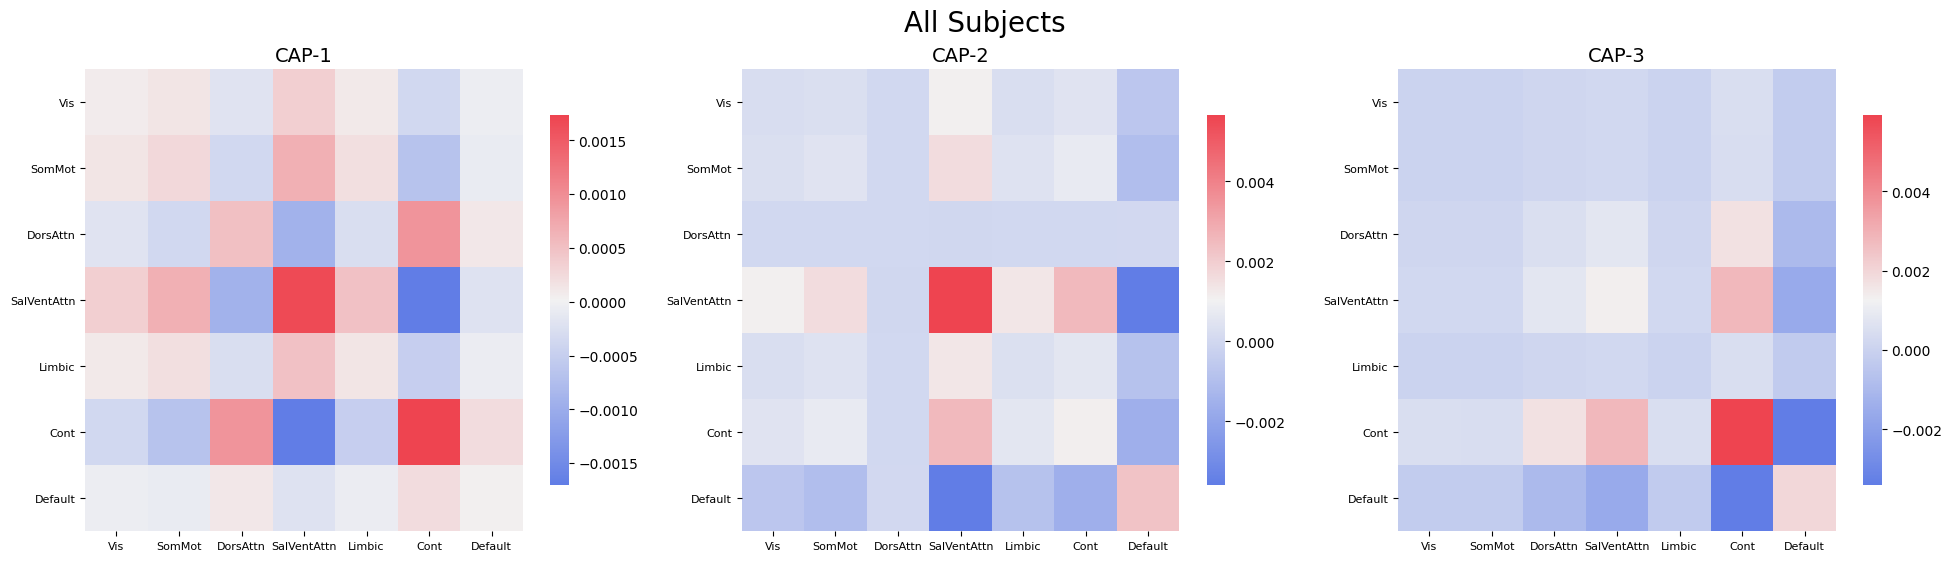

In [13]:
import seaborn as sns
sns.diverging_palette(145, 300, s=60, as_cmap=True)
palette = sns.diverging_palette(260, 10, s=80, l=55, n=256, as_cmap=True)
cap_analysis.caps2plot(visual_scope="regions", plot_options="outer_product", subplots=True, fontsize=14, ncol=6,
                       sharey=False, tight_layout=False, xlabel_rotation=0, hspace = 0.3, cmap=palette)

In [14]:
output = cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries,return_df=True, runs=[1,2])
output["temporal_fraction"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3
0,1,All_Subjects,run-1,0.24,0.36,0.40
1,1,All_Subjects,run-2,0.42,0.30,0.28
2,2,All_Subjects,run-1,0.34,0.30,0.36
3,2,All_Subjects,run-2,0.28,0.28,0.44
4,3,All_Subjects,run-1,0.28,0.34,0.38
5,3,All_Subjects,run-2,0.32,0.36,0.32
6,4,All_Subjects,run-1,0.36,0.32,0.32
7,4,All_Subjects,run-2,0.28,0.38,0.34
8,5,All_Subjects,run-1,0.30,0.28,0.42
9,5,All_Subjects,run-2,0.24,0.36,0.40


In [15]:
cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries,return_df=True, runs=[1,2],
                               continuous_runs=True)

{'temporal_fraction':   Subject_ID         Group              Run     CAP-1     CAP-2     CAP-3
 0          1  All_Subjects  continuous_runs  0.366667  0.326667  0.306667
 1          2  All_Subjects  continuous_runs  0.346667  0.266667  0.386667
 2          3  All_Subjects  continuous_runs  0.300000  0.353333  0.346667
 3          4  All_Subjects  continuous_runs  0.326667  0.340000  0.333333
 4          5  All_Subjects  continuous_runs  0.306667  0.326667  0.366667
 5          6  All_Subjects  continuous_runs  0.300000  0.426667  0.273333,
 'persistence':   Subject_ID         Group              Run     CAP-1     CAP-2     CAP-3
 0          1  All_Subjects  continuous_runs  1.718750  1.361111  1.586207
 1          2  All_Subjects  continuous_runs  1.405405  1.290323  1.812500
 2          3  All_Subjects  continuous_runs  1.406250  1.558824  1.529412
 3          4  All_Subjects  continuous_runs  1.324324  1.342105  1.470588
 4          5  All_Subjects  continuous_runs  1.393939  1.81481

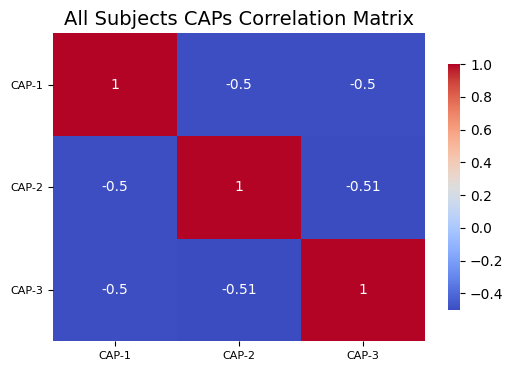

In [16]:
import seaborn as sns
palette = sns.diverging_palette(260, 10, s=80, l=55, n=256, as_cmap=True)
cap_analysis.caps2corr(annot=True, figsize=(6,4))

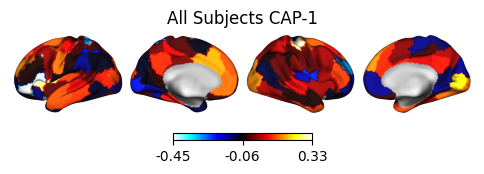

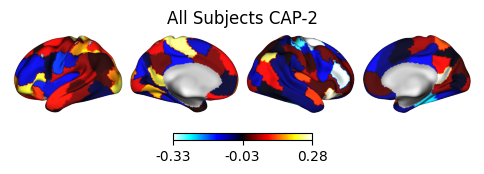

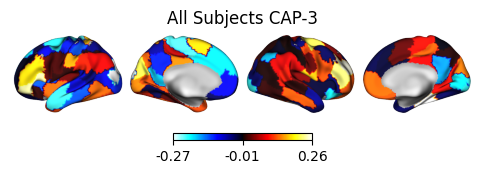

In [17]:
# If you experience coverage issues, usually smoothing helps to mitigate these issues

cap_analysis.caps2surf(cmap="cold_hot", layout="row",  size=(500, 100))

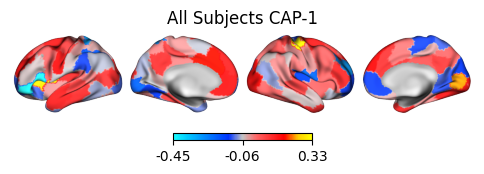

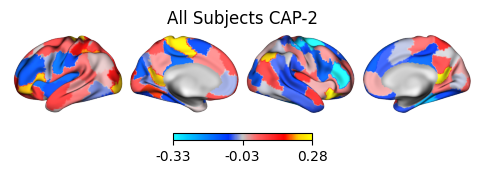

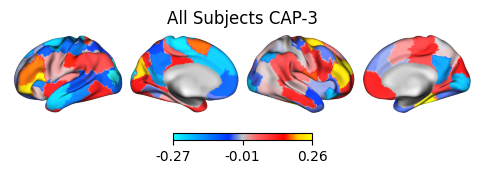

In [18]:
from matplotlib.colors import LinearSegmentedColormap
colors = ["#1bfffe", "#00ccff", "#0099ff", "#0066ff", "#0033ff", "#c4c4c4", "#ff6666", 
          "#ff3333", "#FF0000","#ffcc00","#FFFF00"]

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cold_hot", colors, N=256)
cap_analysis.caps2surf(cmap=custom_cmap, size=(500, 100), layout="row")

In [19]:
radialaxis={"showline": True, "linewidth": 2, "linecolor": "rgba(0, 0, 0, 0.25)", "gridcolor": "rgba(0, 0, 0, 0.25)",
            "ticks": "outside" , "tickfont": {"size": 14, "color": "black"}, "range": [0,0.3],
            "tickvals": [0.1,0.2,0.3]}
cap_analysis.caps2radar(radialaxis=radialaxis, fill="toself", scattersize=10)

In [20]:
os.remove("sample_for_neurocaps_demo_timeseries.pkl")